# At this stage we explain the design of an ACO algorithm, provide a greedy baseline solution, and then present an ACO-based implementation



## Objective Function and Constraints
### Objective Function:
Minimize the overall cost given by the sum of two components:

$$F = P + \sum_{n=1}^{5000} f_n$$

Penalty Component
𝑃:

$$P = \sum_{d=100}^{1} \frac{(N_d - 125)}{400} N_d^{\left(\frac{1}{2} + \frac{|N_d - N_{d+1}|}{50} \right)}$$

where:

𝑁𝑑
is the number of people assigned to day
𝑑.
𝑁𝑑+1​ is the number of people assigned to the next day.
For day 100, assume
𝑁101
=
𝑁100.

Family Penalty 𝑓𝑛:

Each family 𝑛 is assigned a cost based on which priority day they receive. The function
𝑓𝑛 is defined as follows (with 𝑁 as the number of people in the family):

If the 0th day is chosen:
𝑓𝑛
=
0

1st priority:
𝑓𝑛
=
50

2nd priority:
𝑓𝑛
=
50
+
9
𝑁

3rd priority:
𝑓𝑛
=
100
+
9
𝑁

4th priority:
𝑓𝑛
=
200
+
9
𝑁

5th priority:
𝑓𝑛
=
200
+
18
𝑁

6th priority:
𝑓𝑛
=
300
+
18
𝑁

7th priority:
𝑓𝑛
=
300
+
36
𝑁

8th priority:
𝑓𝑛
=
400
+
36
𝑁

9th priority:
𝑓𝑛
=
500
+
235
𝑁 (i.e.,
500
+
36
𝑁
+
199
𝑁)

10th priority:
𝑓𝑛
=
500
+
434
𝑁 (i.e.,
500
+
36
𝑁
+
398
𝑁)

### Constraints:

1. Daily Capacity Constraint:
For each day
𝑑, the total number of people
𝑁𝑑 must be between 125 and 300:
$$125 \leq N_d \leq 300, \quad \forall d \in \{1, 2, \dots, 100\}$$

2. Family Assignment Constraint:
Each family is assigned to exactly one day, and that day must be one of the 10 days specified in their priority list (or a fallback day if none of their preferences can be satisfied).

3. Smoothness Constraint:
To avoid large jumps in daily attendance (which causes a huge penalty in the objective function), the difference between
𝑁𝑑 and 𝑁𝑑+1 should be minimized. In practice, this means the difference should ideally be no more than about 25.


# Research and Design the ACO Algorithm
## Ant Colony Optimization (ACO) for Scheduling Families:

### Graph Representation:

Each node in the graph represents a potential assignment of a family to a day (or, more generally, a decision point for each family).
The ants construct a complete solution by choosing one day (from the family's 10 priority options) for each family.
The decision is guided by pheromone trails and heuristic information.
### Heuristic Information:

The desirability of assigning a family to a given day can be based on how close that day’s current load is to the lower bound (125) while keeping the smooth transition between days (i.e., minimizing
∣𝑁𝑑−𝑁𝑑+1∣).
Other factors include the penalty associated with that family’s priority (the lower the cost
𝑓𝑛​, the better).

###Pheromone Trails:

Pheromone levels are maintained on edges that connect a family with a day.
After each ant constructs a solution (i.e., a full assignment of families to days), the objective function
𝐹 is computed.
Lower-cost solutions deposit more pheromone along the corresponding assignments, thereby reinforcing these choices.

###Ant Decision Rule:

At each decision point (for each family), an ant probabilistically chooses a day using the rule:

$$p_{i,j} = \frac{\tau_{i,j}^\alpha \cdot \eta_{i,j}^\beta}{\sum_{k \in \text{allowed}} \tau_{i,k}^\alpha \cdot \eta_{i,k}^\beta}$$

where:
𝜏 𝑖,𝑗 is the pheromone value for assigning family
𝑖 to day
𝑗. 𝜂 𝑖,𝑗 is the heuristic value (e.g., based on current day load and penalty function
𝑓𝑛).
𝛼 and
𝛽 are parameters that control the influence of pheromone and heuristic information, respectively.

###Pheromone Update:

After all ants have built their solutions, update pheromones by evaporating a fraction of the old pheromone and then adding new pheromone proportional to the quality of each solution.
This helps balance exploration and exploitation.


###Algorithm Iteration:

Repeat the solution construction and pheromone update for a fixed number of iterations or until convergence.
This ACO-based approach is especially useful for our problem because it naturally balances exploration of different scheduling assignments while gradually reinforcing the ones that yield smoother daily attendance and lower family penalties.


## Importing libraries, dataset preparation

In [46]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import plotly.express as px
import time
import random

In [47]:
data_filename = 'data/family_data.csv'
with open(data_filename) as f:
    reader = csv.DictReader(f)
    family_dict = list(reader)

In [48]:
family_dataset = []
for family in family_dict:
  family_data = dict()
  family_data['id'] = int(family['family_id'])
  family_data['n_members'] = int(family['n_people'])
  choise_list = []
  for i in range(10):
    choise_list.append(int(family['choice_' + str(i)]))
  family_data['dates'] = choise_list
  family_dataset.append(family_data)

family_data = sorted(family_dataset, key=lambda d: d['n_members'], reverse=True)

After analyzing the dataset, we noticed that the key value in the final sum for Santa is the penalty:

$$P = \sum_{d=100}^{1} \frac{(N_d - 125)}{400} N_d^{\left(\frac{1}{2} + \frac{|N_d - N_{d+1}|}{50} \right)}$$

Optimal strategies:

- Uniformity: minimize the difference
∣𝑁𝑑−𝑁𝑑+1∣ → smoothing the distribution of people across days.

- Approaching 125: keep 𝑁𝑑 ≈ 125 if possible.

So, let us create greedy algorithm implementing these recommendations

# Greedy algorithm

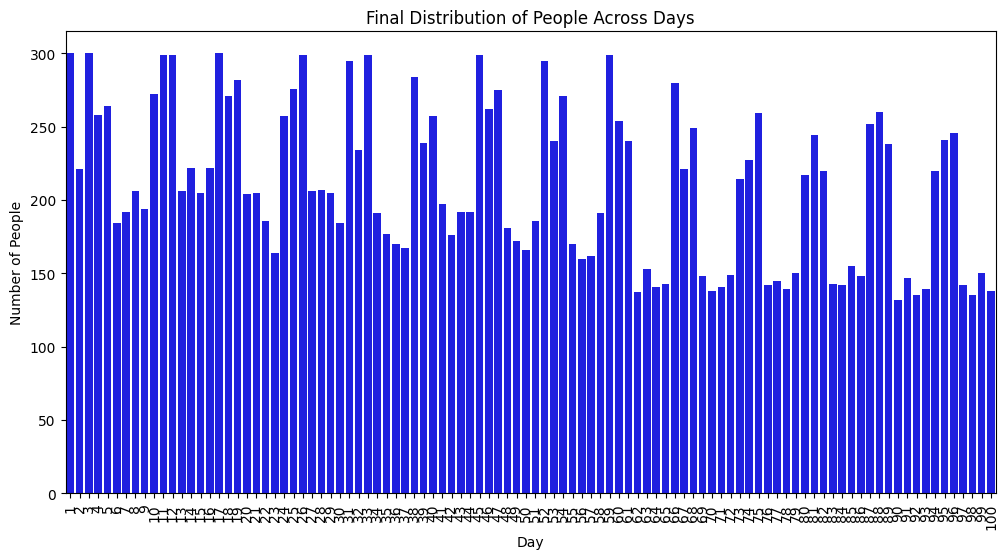

Total Priority Penalty (P): 8718313.42
Total Family Cost: 1777428.00
Final Objective Function (F): 10495741.42
Time the greedy method is working:  2.897345542907715


In [ ]:
DAYS = 100
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300
start_time = time.time()

# Step 1: Initialize schedule and tracking variables
day_capacity = defaultdict(int)  # Stores the number of people assigned to each day
schedule = defaultdict(list)  # Stores assigned families per day
families_sorted = sorted(family_data, key=lambda x: -x['n_members'])  # Sort families by size (descending)

# Step 2: First, ensure each day has at least 125 people
for day in range(1, DAYS + 1):
    day_capacity[day] = 0
    schedule[day] = []
    while day_capacity[day] < MIN_PEOPLE_PER_DAY:
        for family in families_sorted:
            if family['id'] not in schedule[day]:  # Ensure the family isn't already assigned
                if day in family['dates']:  # If this day is in their preferred list
                    if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                        day_capacity[day] += family['n_members']
                        schedule[day].append(family['id'])
                        families_sorted.remove(family)  # Remove assigned families
                        break  # Move to the next day once we assign a family

# Step 3: Assign remaining families while balancing the load
for family in families_sorted:
    for day in family['dates']:
        if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
            day_capacity[day] += family['n_members']
            schedule[day].append(family['id'])
            break  # Assign the family to the first suitable day

# Step 4: Compute the penalty function P
days = sorted(day_capacity.keys())
N_d = np.array([day_capacity[day] for day in days])
P = sum(((N_d[d] - MIN_PEOPLE_PER_DAY) / 400) * (N_d[d] ** (0.5 + abs(N_d[d] - N_d[d+1]) / 50))
        for d in range(DAYS - 1))  # Summing over all days except the last

# Step 5: Compute the cost function f_n for each family
def compute_family_penalty(n_members, priority):
    penalties = [0, 50, 50 + 9 * n_members, 100 + 9 * n_members, 200 + 9 * n_members,
                 200 + 18 * n_members, 300 + 18 * n_members, 300 + 36 * n_members,
                 400 + 36 * n_members, 500 + 235 * n_members, 500 + 434 * n_members]
    return penalties[priority]

total_family_penalty = sum(compute_family_penalty(family['n_members'], family['dates'].index(day) + 1)
                           for day in schedule for family_id in schedule[day]
                           for family in family_data if family['id'] == family_id)

# Step 6: Compute final objective function F
F = P + total_family_penalty

# Step 7: Plot the distribution of people across days
plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=N_d, color='b')
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days")
plt.xticks(rotation=90)
plt.show()

# Print the final penalty values
print(f"Total Priority Penalty (P): {P:.2f}")
print(f"Total Family Cost: {total_family_penalty:.2f}")
print(f"Final Objective Function (F): {F:.2f}")
print("Time the greedy method is working: ", time.time() - start_time)


## The first version of the ACO algorithm

First, let's create and implement the ACO algorithm. As you can see from the results, it works very slowly on such a large dataset. In a minute of work, the program was unable to lower the cost even by 2 times.

Iteration 1, Best Cost so far: 11096328336250.547
Iteration 2, Best Cost so far: 11096328336250.547
Iteration 3, Best Cost so far: 11096328336250.547
Iteration 4, Best Cost so far: 11096328336250.547
Iteration 5, Best Cost so far: 8425689375877.627
Iteration 6, Best Cost so far: 8425689375877.627
Iteration 7, Best Cost so far: 8425689375877.627
Iteration 8, Best Cost so far: 7641431191544.485
Iteration 9, Best Cost so far: 7020537016877.087
Iteration 10, Best Cost so far: 7020537016877.087
Iteration 11, Best Cost so far: 7020537016877.087
Iteration 12, Best Cost so far: 6382634492415.311
Iteration 13, Best Cost so far: 6382634492415.311
Iteration 14, Best Cost so far: 6382634492415.311
Iteration 15, Best Cost so far: 6382634492415.311
Iteration 16, Best Cost so far: 6382634492415.311
Iteration 17, Best Cost so far: 6382634492415.311
Iteration 18, Best Cost so far: 6382634492415.311
Iteration 19, Best Cost so far: 6382634492415.311
Iteration 20, Best Cost so far: 6382634492415.311
Best 

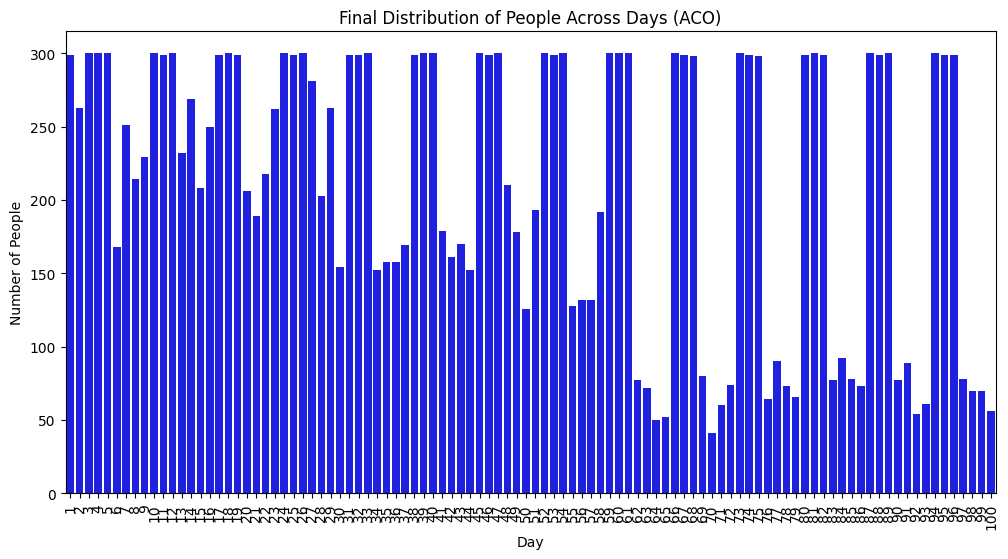

Time the ACO algorithm is working:  53.24052834510803


In [ ]:
start_time = time.time()

# Number of families and days
num_days = 100
num_families = len(family_data)

# Parameters for ACO
num_ants = 10
num_iterations = 20
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic
rho = 0.1    # Evaporation rate

# Initialize pheromone trails: a dictionary mapping (family_id, priority_index) to pheromone level
# For each family, there are 10 possible choices (one for each priority)
pheromones = { (family['id'], i): 1.0 for family in family_data for i in range(10) }

# Heuristic information: lower cost is more desirable.
# Here, we use the inverse of the family penalty for a given priority.
def family_penalty(family, priority):
    N = family['n_members']
    # Define the penalty function as per given rules:
    penalties = [
        0,
        50,
        50 + 9 * N,
        100 + 9 * N,
        200 + 9 * N,
        200 + 18 * N,
        300 + 18 * N,
        300 + 36 * N,
        400 + 36 * N,
        500 + 434 * N  # 10th priority
    ]
    return penalties[priority]

# The heuristic desirability is the inverse of the penalty (adding a small constant to avoid division by zero)
def heuristic(family, priority):
    return 1.0 / (family_penalty(family, priority) + 1e-6)

# Evaluate a complete solution: assign each family to a day according to chosen priority
def compute_P(daily_load):
    P = 0
    sorted_days = sorted(daily_load.keys())

    for i, day in enumerate(sorted_days):
        Nd = daily_load[day]
        Nd_next = daily_load[sorted_days[i+1]] if i < len(sorted_days) - 1 else Nd
        P += ((Nd - 125) / 400) * (Nd ** (0.5 + abs(Nd - Nd_next) / 50))

    return P

def evaluate_solution(solution):
    daily_load = {day: 0 for day in range(1, num_days+1)}
    total_family_penalty = 0

    for family in family_data:
        fam_id = family['id']
        if fam_id in solution:
            day, priority = solution[fam_id]
            total_family_penalty += family_penalty(family, priority)
            daily_load[day] += family['n_members']

    P = compute_P(daily_load)
    return P + total_family_penalty, daily_load

# Construct solution for one ant
def construct_solution():
    solution = {}  # mapping family id -> (assigned day, chosen priority)
    # Create a copy of daily capacity for assignment
    current_load = {day: 0 for day in range(1, num_days+1)}

    # Shuffle families to add stochasticity
    families = family_data.copy()
    random.shuffle(families)

    for family in families:
        fam_id = family['id']
        probabilities = []
        choices = []
        # For each of the 10 priorities, check if assignment is possible
        for priority in range(10):
            # Get the day corresponding to this priority
            day = family['dates'][priority]
            if current_load[day] + family['n_members'] <= 300:
                tau = pheromones[(fam_id, priority)]
                eta = heuristic(family, priority)
                prob = (tau ** alpha) * (eta ** beta)
                probabilities.append(prob)
                choices.append((day, priority))
            else:
                probabilities.append(0)
                choices.append((None, priority))

        # Normalize probabilities if sum > 0
        total = sum(probabilities)
        if total > 0:
            probabilities = [p / total for p in probabilities]
            # Roulette wheel selection for priority
            selected_index = np.random.choice(range(10), p=probabilities)
            selected_day, selected_priority = choices[selected_index]
        else:
            # If no priority is feasible, assign to a random day that can accept the family
            possible_days = [day for day in range(1, num_days+1) if current_load[day] + family['n_members'] <= 300]
            if possible_days:
                selected_day = random.choice(possible_days)
                selected_priority = 0  # Use a default priority penalty (could be set high)
            else:
                # This family cannot be assigned; for feasibility, assign to a random day
                selected_day = random.randint(1, num_days)
                selected_priority = 0
        # Update solution and current load
        solution[fam_id] = (selected_day, selected_priority)
        current_load[selected_day] += family['n_members']

    return solution

# ACO main loop
best_solution = None
best_cost = float('inf')

for iteration in range(num_iterations):
    all_solutions = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, load = evaluate_solution(sol)
        all_solutions.append((sol, cost))
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    # Update pheromones: evaporation and reinforcement
    for key in pheromones:
        pheromones[key] *= (1 - rho)

    # Deposit pheromones from best solutions found in this iteration
    for sol, cost in all_solutions:
        # Use inverse cost as deposit amount
        deposit = 1.0 / (cost + 1e-6)
        for family in family_data:
            fam_id = family['id']
            if fam_id in sol:
                _, priority = sol[fam_id]
                pheromones[(fam_id, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost}")

# Print best solution and corresponding daily load distribution
final_cost, final_load = evaluate_solution(best_solution)
print("Best Overall Cost:", final_cost)
print("Daily Load Distribution:", final_load)

# Plot the final daily distribution
days = sorted(final_load.keys())
people_counts = [final_load[day] for day in days]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.xticks(rotation=90)
plt.show()
print("Time the ACO algorithm is working: ", time.time() - start_time)

We notice that increasing the number of ants or cycles does not improve the result. Perhaps the program works poorly because the initial solution is built inefficiently. Then we will try to combine the ACO with a greedy algorithm, which gives a good starting point.

## Combining the greedy algorithm with the first version of the ACO

Greedy solution cost: 9956185.801814528
Iteration 1, Best Cost so far: 9956185.80
Iteration 2, Best Cost so far: 9956185.80
Iteration 3, Best Cost so far: 9956185.80
Iteration 4, Best Cost so far: 9956185.80
Iteration 5, Best Cost so far: 9956185.80
Iteration 6, Best Cost so far: 9956185.80
Iteration 7, Best Cost so far: 9956185.80
Iteration 8, Best Cost so far: 9956185.80
Iteration 9, Best Cost so far: 9956185.80
Iteration 10, Best Cost so far: 9956185.80
Iteration 11, Best Cost so far: 9956185.80
Iteration 12, Best Cost so far: 9956185.80
Iteration 13, Best Cost so far: 9956185.80
Iteration 14, Best Cost so far: 9956185.80
Iteration 15, Best Cost so far: 9956185.80
Iteration 16, Best Cost so far: 9956185.80
Iteration 17, Best Cost so far: 9956185.80
Iteration 18, Best Cost so far: 9956185.80
Iteration 19, Best Cost so far: 9956185.80
Iteration 20, Best Cost so far: 9956185.80
Iteration 21, Best Cost so far: 9956185.80
Iteration 22, Best Cost so far: 9956185.80
Iteration 23, Best Cost

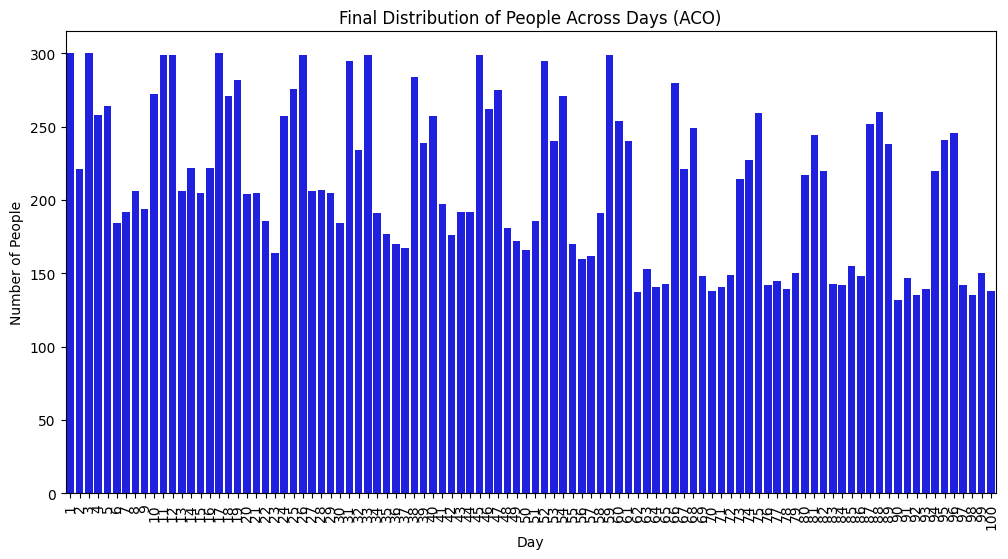

In [ ]:
DAYS = 100
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300

# ACO parameters
num_ants = 50
num_iterations = 50
alpha = 1.0   # influence of pheromone
beta = 2.0    # influence of heuristic
rho = 0.1     # evaporation rate
start_time = time.time()


# Initialize pheromone trails: dictionary mapping (family_id, priority_index) -> pheromone level
pheromones = {(family['id'], i): 1.0 for family in family_data for i in range(10)}

# Precompute heuristic values for each family and each priority
# Heuristic is the inverse of the family penalty
def compute_family_penalty(n_members, priority):
    penalties = [0,
                 50,
                 50 + 9 * n_members,
                 100 + 9 * n_members,
                 200 + 9 * n_members,
                 200 + 18 * n_members,
                 300 + 18 * n_members,
                 300 + 36 * n_members,
                 400 + 36 * n_members,
                 500 + 434 * n_members]
    return penalties[priority]

heuristic_cache = {}  # (family_id, priority) -> heuristic value
for family in family_data:
    for priority in range(10):
        penalty = compute_family_penalty(family['n_members'], priority)
        heuristic_cache[(family['id'], priority)] = 1.0 / (penalty + 1e-6)

# Evaluation function for a complete solution
def evaluate_solution(solution):
    # solution: dict mapping family id -> (assigned day, chosen priority)
    daily_load = {day: 0 for day in range(1, DAYS+1)}
    total_family_penalty = 0
    for family in family_data:
        fid = family['id']
        if fid in solution:
            assigned_day, priority = solution[fid]
            total_family_penalty += compute_family_penalty(family['n_members'], priority)
            daily_load[assigned_day] += family['n_members']
    # Compute penalty P for day load differences
    P = 0
    sorted_days = sorted(daily_load.keys())
    for i, day in enumerate(sorted_days):
        Nd = daily_load[day]
        Nd_next = daily_load[sorted_days[i+1]] if i < len(sorted_days) - 1 else Nd
        P += ((Nd - MIN_PEOPLE_PER_DAY) / 400) * (Nd ** (0.5 + abs(Nd - Nd_next) / 50))
    return P + total_family_penalty, daily_load

# Greedy algorithm to get a fast feasible solution (used for warm-start)
def greedy_solution():
    day_capacity = {day: 0 for day in range(1, DAYS+1)}
    schedule = defaultdict(list)
    families_sorted = sorted(family_data, key=lambda x: -x['n_members'])
    # First, fill each day with at least MIN_PEOPLE_PER_DAY if possible
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY:
            for family in families_sorted.copy():
                if day in family['dates'] and family['id'] not in schedule[day]:
                    if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                        day_capacity[day] += family['n_members']
                        schedule[day].append(family['id'])
                        families_sorted.remove(family)
                        break
            else:
                break  # no available family, break while loop
    # Then assign remaining families by their preference order
    for family in families_sorted:
        for day in family['dates']:
            if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                day_capacity[day] += family['n_members']
                schedule[day].append(family['id'])
                break
    # Build solution mapping: family id -> (assigned day, priority index as per family's list)
    sol = {}
    for day, fid_list in schedule.items():
        for fid in fid_list:
            # Get the family and determine the priority by checking position of day in their dates list
            fam = next(f for f in family_data if f['id'] == fid)
            priority = fam['dates'].index(day) if day in fam['dates'] else 9
            sol[fid] = (day, priority)
    return sol

# Get greedy solution and its cost
greedy_sol = greedy_solution()
greedy_cost, greedy_daily_load = evaluate_solution(greedy_sol)
best_solution = greedy_sol
best_cost = greedy_cost

print("Greedy solution cost:", best_cost)

# ACO: Construct solution for one ant using cached heuristic values
def construct_solution():
    solution = {}
    current_load = {day: 0 for day in range(1, DAYS+1)}
    families = family_data.copy()
    random.shuffle(families)
    for family in families:
        fid = family['id']
        prob_list = []
        choices = []
        for priority in range(10):
            day = family['dates'][priority]
            if current_load[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                tau = pheromones[(fid, priority)]
                eta = heuristic_cache[(fid, priority)]
                prob = (tau ** alpha) * (eta ** beta)
                prob_list.append(prob)
                choices.append((day, priority))
            else:
                prob_list.append(0)
                choices.append((None, priority))
        total_prob = sum(prob_list)
        if total_prob > 0:
            norm_probs = [p / total_prob for p in prob_list]
            selected_index = np.random.choice(range(10), p=norm_probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            # Fallback: choose a random day that can accept the family
            possible_days = [day for day in range(1, DAYS+1) if current_load[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY]
            if possible_days:
                selected_day = random.choice(possible_days)
                selected_priority = 0
            else:
                selected_day = random.randint(1, DAYS)
                selected_priority = 0
        solution[fid] = (selected_day, selected_priority)
        current_load[selected_day] += family['n_members']
    return solution


# ACO main loop
for iteration in range(num_iterations):
    solutions = []
    costs = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, load = evaluate_solution(sol)
        solutions.append(sol)
        costs.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    # Pheromone evaporation
    for key in pheromones:
        pheromones[key] *= (1 - rho)
    # Reinforce pheromones from each solution (using inverse cost)
    for sol, cost in zip(solutions, costs):
        deposit = 1.0 / (cost + 1e-6)
        for family in family_data:
            fid = family['id']
            if fid in sol:
                _, priority = sol[fid]
                pheromones[(fid, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost:.2f}")

end_time = time.time()

final_cost, final_load = evaluate_solution(best_solution)
print("Best Overall Cost (F):", final_cost)
print("Final Daily Load Distribution:", final_load)
total_people_assigned = sum(final_load.values())
print("Total Number of People Assigned:", total_people_assigned)
print("Greedy Algorithm with ACO Time (s):", end_time - start_time)

# Plot the final distribution
days = sorted(final_load.keys())
people_counts = [final_load[day] for day in days]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.xticks(rotation=90)
plt.show()


Changing the start data did not improve the algorithm in any way. This means that the ACO algorithm itself is implemented inefficiently. By analyzing the algorithm, we notice that in the construct_solution() function, that is, at the stage of calculating the Ant Decision Rule, we do not take into account the change in Penalty Component 𝑃. When assigning a family to a specific day, the difference between the number of visitors between adjacent days changes. Moreover, P changes not only for this day, but also for the previous one. Let's rewrite the ACO algorithm taking these changes into account.

## The second version of the ACO algorithm

Iteration 1, Best Cost so far: 8579932.025605153
Iteration 2, Best Cost so far: 8579932.025605153
Iteration 3, Best Cost so far: 8579932.025605153
Iteration 4, Best Cost so far: 7937572.333753702
Iteration 5, Best Cost so far: 6873500.043677666
Iteration 6, Best Cost so far: 6873500.043677666
Iteration 7, Best Cost so far: 6873500.043677666
Iteration 8, Best Cost so far: 6873500.043677666
Iteration 9, Best Cost so far: 6563398.302010613
Iteration 10, Best Cost so far: 6563398.302010613
Iteration 11, Best Cost so far: 6563398.302010613
Iteration 12, Best Cost so far: 6563398.302010613
Iteration 13, Best Cost so far: 6563398.302010613
Iteration 14, Best Cost so far: 6049905.008504928
Iteration 15, Best Cost so far: 5896582.871203712
Iteration 16, Best Cost so far: 5884768.117978938
Iteration 17, Best Cost so far: 5884768.117978938
Iteration 18, Best Cost so far: 5884768.117978938
Iteration 19, Best Cost so far: 3675173.981927487
Iteration 20, Best Cost so far: 3675173.981927487
Iteration

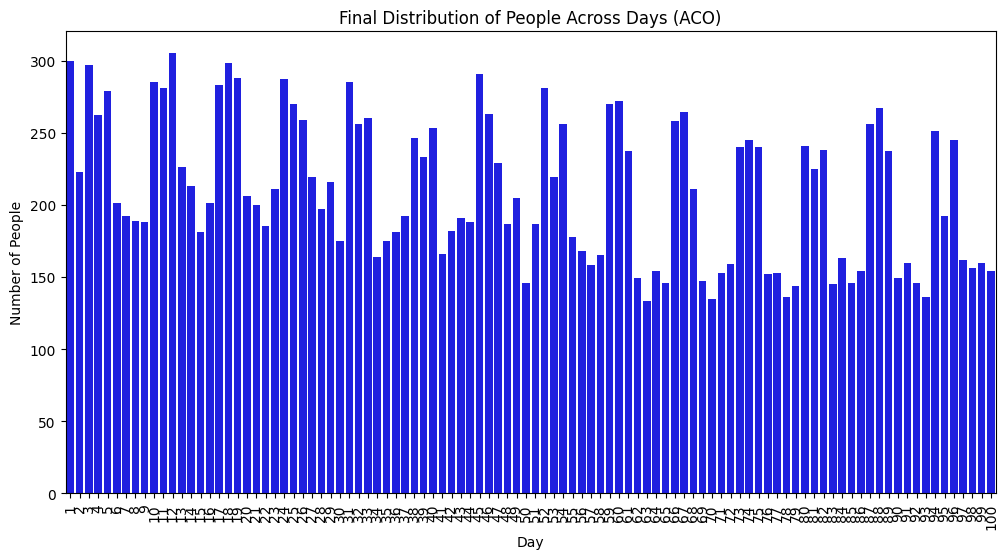

Time the ACO algorithm is working: 633.2610092163086


In [58]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

start_time = time.time()

# Number of families and days
num_days = 100
num_families = len(family_data)

# Parameters for ACO
num_ants = 5
num_iterations = 50
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic
rho = 0.1    # Evaporation rate

# Initialize pheromone trails
pheromones = { (family['id'], i): 1.0 for family in family_data for i in range(10) }

def family_penalty(family, priority):
    N = family['n_members']
    penalties = [0, 50, 50 + 9 * N, 100 + 9 * N, 200 + 9 * N,
                 200 + 18 * N, 300 + 18 * N, 300 + 36 * N,
                 400 + 36 * N, 500 + 235 * N , 500 + 434 * N]
    return penalties[priority]

def heuristic(family, priority):
    return 1.0 / (family_penalty(family, priority) + 1e-6)

def compute_P(daily_load):
    P = 0
    sorted_days = sorted(daily_load.keys())

    for i, day in enumerate(sorted_days):
        Nd = daily_load[day]
        Nd_next = daily_load[sorted_days[i+1]] if i < len(sorted_days) - 1 else Nd
        P += (abs(Nd - 125) / 400) * (Nd ** (0.5 + abs(Nd - Nd_next) / 50))

    return P

def evaluate_solution(solution):
    daily_load = {day: 0 for day in range(1, num_days+1)}
    total_family_penalty = 0

    for family in family_data:
        fam_id = family['id']
        if fam_id in solution:
            day, priority = solution[fam_id]
            total_family_penalty += family_penalty(family, priority)
            daily_load[day] += family['n_members']

    P = compute_P(daily_load)
    return P + total_family_penalty, daily_load

def construct_solution():
    solution = {}
    current_load = {day: 0 for day in range(1, num_days+1)}
    families = family_data.copy()
    random.shuffle(families)

    for family in families:
        fid = family['id']
        prob_list = []
        choices = []

        for priority in range(10):
            day = family['dates'][priority]
            if current_load[day] + family['n_members'] <= 300:
                tau = pheromones[(fid, priority)]
                eta = heuristic(family, priority)

                temp_load = current_load.copy()
                temp_load[day] += family['n_members']
                P_new = compute_P(temp_load)
                delta_P = P_new
                penalty_factor = 1/(delta_P +1e-6)
                if current_load[day] >= 125:
                    prob = (tau ** alpha) * (eta ** beta) * (penalty_factor**3)
                else:
                    prob = (tau ** alpha) * (eta ** beta)
                prob_list.append(prob)
                choices.append((day, priority))
            else:
                prob_list.append(0)
                choices.append((None, priority))

        total_prob = sum(prob_list)
        if total_prob > 1e-9:
            norm_probs = [p / total_prob for p in prob_list]
            selected_index = np.random.choice(range(10), p=norm_probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            selected_day = random.randint(1, num_days)
            selected_priority = 10

        solution[fid] = (selected_day, selected_priority)
        current_load[selected_day] += family['n_members']

    return solution

best_solution = None
best_cost = float('inf')

for iteration in range(num_iterations):
    all_solutions = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, load = evaluate_solution(sol)
        all_solutions.append((sol, cost))
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    for key in pheromones:
        pheromones[key] *= (1 - rho)

    for sol, cost in all_solutions:
        deposit = 1.0 / (cost + 1e-6)
        for family in family_data:
            fam_id = family['id']
            if fam_id in sol:
                _, priority = sol[fam_id]
                if priority <10:
                    pheromones[(fam_id, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost}")

final_cost, final_load = evaluate_solution(best_solution)
print("Best Overall Cost:", final_cost)
print("Daily Load Distribution:", final_load)

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted(final_load.keys()), y=[final_load[day] for day in sorted(final_load.keys())], color='b')
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.xticks(rotation=90)
plt.show()
print("Time the ACO algorithm is working:", time.time() - start_time)


Greedy solution cost: 9702460.801814528
Iteration 1, Best Cost so far: 9702460.80
Iteration 2, Best Cost so far: 9702460.80
Iteration 3, Best Cost so far: 9702460.80
Iteration 4, Best Cost so far: 9702460.80
Iteration 5, Best Cost so far: 9702460.80
Iteration 6, Best Cost so far: 9702460.80
Iteration 7, Best Cost so far: 9702460.80
Iteration 8, Best Cost so far: 9702460.80
Iteration 9, Best Cost so far: 9702460.80
Iteration 10, Best Cost so far: 9702460.80
Iteration 11, Best Cost so far: 9702460.80
Iteration 12, Best Cost so far: 9702460.80
Iteration 13, Best Cost so far: 9702460.80
Iteration 14, Best Cost so far: 9702460.80
Iteration 15, Best Cost so far: 9702460.80
Iteration 16, Best Cost so far: 9702460.80
Iteration 17, Best Cost so far: 9702460.80
Iteration 18, Best Cost so far: 9702460.80
Iteration 19, Best Cost so far: 9702460.80
Iteration 20, Best Cost so far: 9702460.80
Iteration 21, Best Cost so far: 9702460.80
Iteration 22, Best Cost so far: 9702460.80
Iteration 23, Best Cost

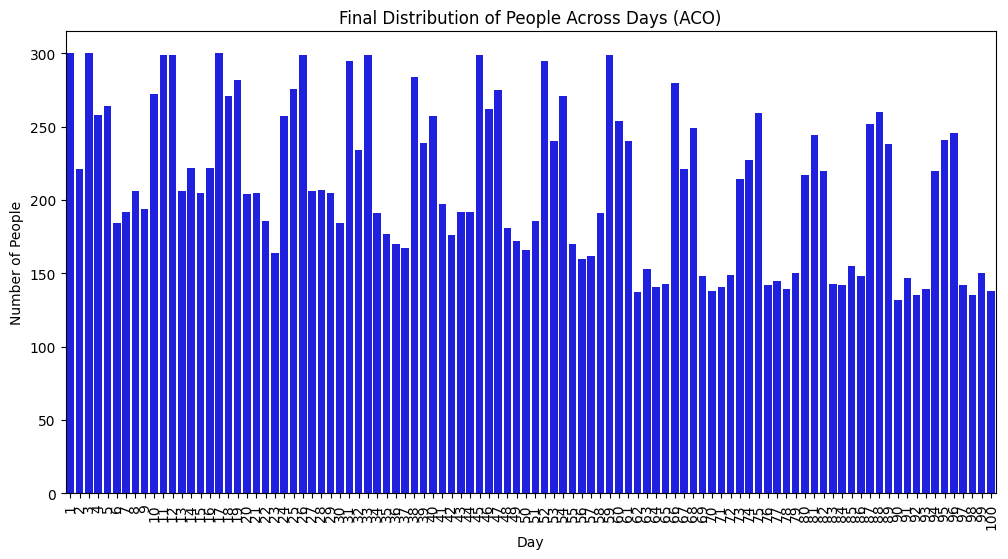

In [59]:
def compute_family_penalty(n_members, priority):
    penalties = [0,
                 50,
                 50 + 9 * n_members,
                 100 + 9 * n_members,
                 200 + 9 * n_members,
                 200 + 18 * n_members,
                 300 + 18 * n_members,
                 300 + 36 * n_members,
                 400 + 36 * n_members,
                 500 + 235 * n_members,
                 500 + 434 * n_members]
    return penalties[priority]

def compute_P(daily_load):
    P = 0
    sorted_days = sorted(daily_load.keys())

    for i, day in enumerate(sorted_days):
        Nd = daily_load[day]
        Nd_next = daily_load[sorted_days[i+1]] if i < len(sorted_days) - 1 else Nd
        P += (abs(Nd - 125) / 400) * (Nd ** (0.5 + abs(Nd - Nd_next) / 50))

    return P


def evaluate_solution(solution):
    daily_load = {day: 0 for day in range(1, num_days+1)}
    total_family_penalty = 0

    for family in family_data:
        fam_id = family['id']
        if fam_id in solution:
            day, priority = solution[fam_id]
            total_family_penalty += family_penalty(family, priority)
            daily_load[day] += family['n_members']

    P = compute_P(daily_load)

    return P + total_family_penalty, daily_load


# Greedy algorithm to get a fast feasible solution (used for warm-start)
def greedy_solution():
    day_capacity = {day: 0 for day in range(1, DAYS+1)}
    schedule = defaultdict(list)
    families_sorted = sorted(family_data, key=lambda x: -x['n_members'])
    # First, fill each day with at least MIN_PEOPLE_PER_DAY if possible
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY:
            for family in families_sorted.copy():
                if day in family['dates'] and family['id'] not in schedule[day]:
                    if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                        day_capacity[day] += family['n_members']
                        schedule[day].append(family['id'])
                        families_sorted.remove(family)
                        break
            else:
                break  # no available family, break while loop
    # Then assign remaining families by their preference order
    for family in families_sorted:
        for day in family['dates']:
            if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                day_capacity[day] += family['n_members']
                schedule[day].append(family['id'])
                break
    # Build solution mapping: family id -> (assigned day, priority index as per family's list)
    sol = {}
    for day, fid_list in schedule.items():
        for fid in fid_list:
            # Get the family and determine the priority by checking position of day in their dates list
            fam = next(f for f in family_data if f['id'] == fid)
            priority = fam['dates'].index(day) if day in fam['dates'] else 9
            sol[fid] = (day, priority)
    return sol


# ACO: Construct solution for one ant using cached heuristic values
def construct_solution():
    solution = {}
    current_load = {day: 0 for day in range(1, DAYS+1)}
    families = family_data.copy()
    random.shuffle(families)

    for family in families:
        fid = family['id']
        prob_list = []
        choices = []

        for priority in range(10):
            day = family['dates'][priority]

            if current_load[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:

                current_load[day] += family['n_members']
                new_P = compute_P(current_load)
                delta_P = new_P
                current_load[day] -= family['n_members']


                tau = pheromones[(fid, priority)]
                eta = heuristic_cache[(fid, priority)] * np.exp(-delta_P)
                penalty_factor = 1/(delta_P +1e-6)
                if current_load[day] >= 125:
                    prob = (tau ** alpha) * (eta ** beta) * (penalty_factor**3)
                else:
                    prob = (tau ** alpha) * (eta ** beta)
                prob_list.append(prob)
                choices.append((day, priority))
            else:
                prob_list.append(0)
                choices.append((None, priority))

        total_prob = sum(prob_list)

        if total_prob > 0:
            norm_probs = [p / total_prob for p in prob_list]
            selected_index = np.random.choice(range(10), p=norm_probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            possible_days = [day for day in range(1, DAYS+1) if current_load[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY]
            if possible_days:
                selected_day = random.choice(possible_days)
                selected_priority = 10
            else:
                selected_day = random.randint(1, DAYS)
                selected_priority = 10

        solution[fid] = (selected_day, selected_priority)
        current_load[selected_day] += family['n_members']

    return solution

DAYS = 100
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300

# ACO parameters
num_ants = 5
num_iterations = 50
alpha = 1.0   # influence of pheromone
beta = 2.0    # influence of heuristic
rho = 0.1     # evaporation rate
start_time = time.time()

# Initialize pheromone trails: dictionary mapping (family_id, priority_index) -> pheromone level
pheromones = {(family['id'], i): 1.0 for family in family_data for i in range(10)}

heuristic_cache = {}  # (family_id, priority) -> heuristic value
for family in family_data:
    for priority in range(10):
        penalty = compute_family_penalty(family['n_members'], priority)
        heuristic_cache[(family['id'], priority)] = 1.0 / (penalty + 1e-6)

# Get greedy solution and its cost
greedy_sol = greedy_solution()
greedy_cost, greedy_daily_load = evaluate_solution(greedy_sol)
best_solution = greedy_sol
best_cost = greedy_cost

print("Greedy solution cost:", best_cost)

# ACO main loop
for iteration in range(num_iterations):
    solutions = []
    costs = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, load = evaluate_solution(sol)
        solutions.append(sol)
        costs.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    # Pheromone evaporation
    for key in pheromones:
        pheromones[key] *= (1 - rho)
    # Reinforce pheromones from each solution (using inverse cost)
    for sol, cost in zip(solutions, costs):
        deposit = 1.0 / (cost + 1e-6)
        for family in family_data:
            fid = family['id']
            if fid in sol:
                _, priority = sol[fid]
                if priority < 10:
                    pheromones[(fid, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost:.2f}")

end_time = time.time()

final_cost, final_load = evaluate_solution(best_solution)
print("Best Overall Cost (F):", final_cost)
print("Final Daily Load Distribution:", final_load)
total_people_assigned = sum(final_load.values())
print("Total Number of People Assigned:", total_people_assigned)
print("Greedy Algorithm with ACO Time (s):", end_time - start_time)

# Plot the final distribution
days = sorted(final_load.keys())
people_counts = [final_load[day] for day in days]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.xticks(rotation=90)
plt.show()


Based on the data obtained, we came to the conclusion that the ACO does not need to provide initial conditions.